## Climate Analysis and Exploration
### Class:  USC Viterbi Data Analytics Bootcamp
### Student:  Patrick Humphries
### Date:  20 April 2018

*Summary*<br/>
Percipitation and temperature are analyzed.  The source of the data and metadata was the database hawaii.sqlite.

### Data Preparation

In [1]:
# Import Dependencies
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func
from sqlalchemy import and_

In [3]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [5]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the Measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement

In [8]:
# Assign the Station class to a variable called `Station`
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

In [10]:
# Use the session to query Measurement table and display the first 5 rows.
for row in session.query(Measurement, Measurement.station).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x0000029235E5C390>, 'USC00519397')
(<sqlalchemy.ext.automap.measurement object at 0x0000029235E5C400>, 'USC00519397')
(<sqlalchemy.ext.automap.measurement object at 0x0000029235E5C470>, 'USC00519397')
(<sqlalchemy.ext.automap.measurement object at 0x0000029235E5C4E0>, 'USC00519397')
(<sqlalchemy.ext.automap.measurement object at 0x0000029235E5C550>, 'USC00519397')


In [11]:
# BONUS: Query and print the number of unique Stations
# Hints: Look into counting and grouping operations in SQLAlchemy
stations = session.query(Measurement).group_by(Measurement.station).count()
print(stations)

9



### Precipitation Analysis

Percipitation for a twelve-month period is aggregated by month and plotted.
The requirements was for plotting by day.
However, that proved to be too granular.
Aggregating by month yields a more meaningful view.

In [12]:
# Determine the maximum date string in Measurements. 
rs = session.query(func.max(Measurement.date))
max_date_str = rs[0][0]
print(max_date_str)

2017-08-23


In [13]:
# Convert the maximum date string to a date for calculation.
max_date = datetime.strptime(max_date_str, '%Y-%m-%d')
print(type(max_date))

<class 'datetime.datetime'>


In [14]:
# Calculate the delta for the last twelve months.
from datetime import timedelta
one_year = timedelta(335)

In [15]:
# Calculate the date 12 months ago.
min_date = max_date - one_year

In [16]:
# Convert the date 12 months ago to a string for comparison.
min_date_str = datetime.strftime(min_date, '%Y-%m-%d')
print(min_date_str)

2016-09-22


In [17]:
# Select the year, month, and the percipitation for the month.
# This deviates from the requirements for legibility.
rs = session \
    .query(func.substr(Measurement.date, 1, 7), func.sum(Measurement.prcp)) \
    .filter(and_(Measurement.date > min_date_str, Measurement.date <= max_date_str )) \
    .group_by(func.substr(Measurement.date, 1, 7)) \
    .all()

In [18]:
# Convert the result set to a list for processing.
rs_list = list(rs)

In [19]:
# Create the dataframe of percipitation by month.
labels = ['Month', 'Percipitation']
df_prcp = pd.DataFrame(rs_list, columns=labels)
df_prcp.head(12)

,Month,Percipitation
0,2016-09,9.24
1,2016-10,21.77
2,2016-11,20.56
3,2016-12,35.51
4,2017-01,11.95
5,2017-02,39.06
6,2017-03,29.62
7,2017-04,54.91
8,2017-05,25.27
9,2017-06,20.52


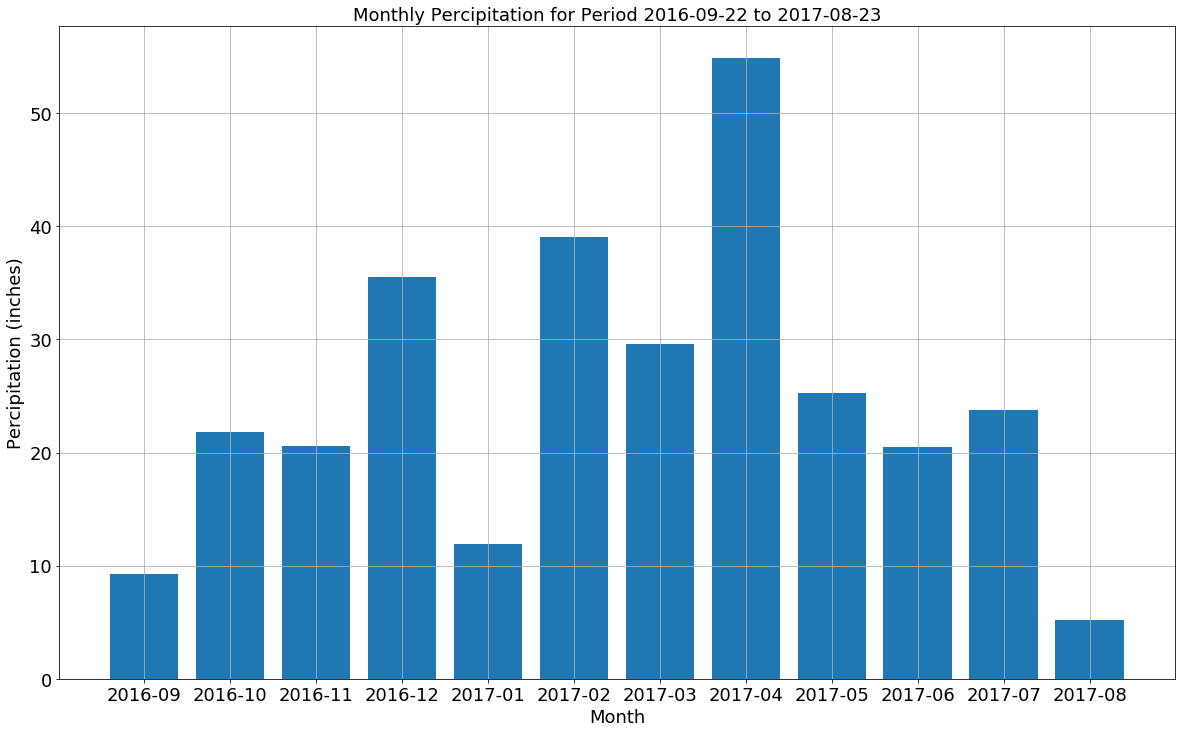

In [20]:
# Plot percipitation by month.
month_list = list(df_prcp.Month)
percipitation_list = list(df_prcp.Percipitation)


plt.figure(figsize=(20,12))
plt.title('Monthly Percipitation for Period {} to {}'.format(min_date_str, max_date_str), fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.legend(prop={'size': 18})
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Percipitation (inches)', fontsize=18)
plt.xlabel('Month', fontsize=18)
plt.grid(True)
plt.bar(month_list, percipitation_list)
plt.show()

### Station Analysis

For the station with the most temperature readings, plot the frequence of a temperature.


In [21]:
# Total number of stations.
station_count = session.query(Station).count()
print("Total Number of Stations:", str(station_count))

Total Number of Stations: 9


In [22]:
# Design a query to find the most active stations.
rs = session \
    .query(Measurement.station, func.count(Measurement.station)) \
    .filter(and_(Measurement.date > min_date_str, Measurement.date <= max_date_str )) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()

In [23]:
# Convert the result set to a list for processing.
rs_list = list(rs)

In [24]:
# List of stations in descending order.
for rs_entry in rs_list:
    print(rs_entry)

('USC00519397', 330)
('USC00519281', 321)
('USC00513117', 312)
('USC00516128', 299)
('USC00519523', 285)
('USC00514830', 245)
('USC00517948', 54)


In [25]:
# Select the most active station.
rs = session \
    .query(Measurement.station, func.count(Measurement.station)) \
    .filter(and_(Measurement.date > min_date_str, Measurement.date <= max_date_str )) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .limit(1)

In [26]:
# Convert the result set to a list for processing.
rs_list = list(rs)

In [27]:
# Display the the most active station.
station_with_most_tobs = rs_list[0][0]
print(station_with_most_tobs)

USC00519397


In [28]:
# Query temperature observations for the last 12 months for the station with the highest number of observations.
rs = session \
    .query(Measurement.tobs) \
    .filter(and_(Measurement.date > min_date_str, \
                 Measurement.date <= max_date_str, \
                 Measurement.station == station_with_most_tobs )) \
    .all()

In [29]:
# Convert the result set to a list for processing.
rs_list = list(rs)

In [30]:
# Convert list of tuples to a list of temperatures.
tobs_list = []
for rs_entry in rs_list:
    tobs_list.append(rs_entry[0])  

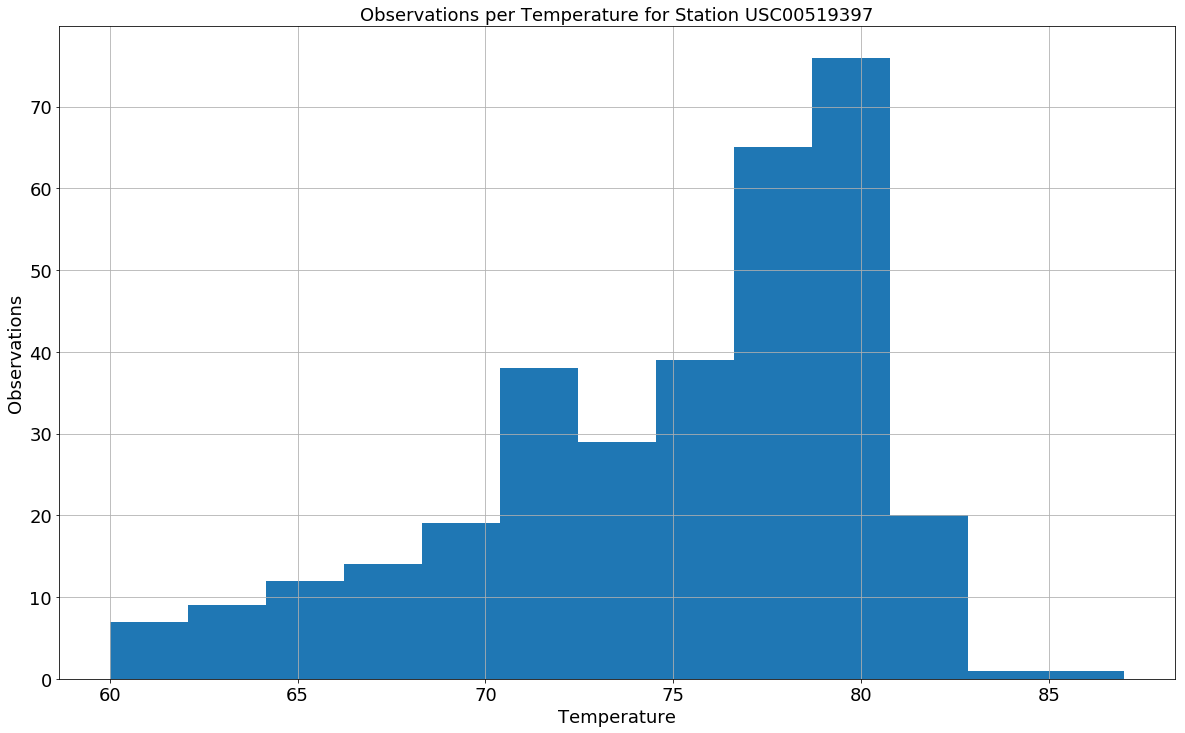

In [31]:
# Plot number observations per temperature.
plt.figure(figsize=(20,12))
plt.title('Observations per Temperature for Station {}'.format(station_with_most_tobs), fontsize=18)
plt.ylabel('Observations', fontsize=18)
plt.xlabel('Temperature', fontsize=18)
plt.yticks(np.arange(0,100,10), fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)
n, bins, patches = plt.hist(tobs_list, 13, density=False)
plt.show()

### Temperature Analysis

For a given timeperiod, plot an analysis of the temperatures from the station with the most observations.



In [32]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
# and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(min_date_str, max_date_str):
    max_date = datetime.strptime(max_date_str, '%Y-%m-%d')
    min_date = datetime.strptime(min_date_str, '%Y-%m-%d')
    min_temp = 0
    avg_temp = 0
    max_temp = 0
    
    
    rs = session \
    .query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)) \
    .filter(and_(Measurement.date > min_date_str, Measurement.date <= max_date_str )) \
    .all()
    
    min_temp = rs[0][0]
    avg_temp = rs[0][1]
    max_temp = rs[0][2]
    
    return min_temp, avg_temp, max_temp

In [33]:
# Minimum, average, and maximum temperatures for the planned trip.
min_t, avg_t, max_t = calc_temps('2017-01-01', '2017-01-10')
print("Min:", str(min_t), "Avg:", str(avg_t), "Max:", str(max_t))

Min: 60.0 Avg: 67.90384615384616 Max: 77.0


In [34]:
# Minimum, average, and maximum tempteratures for the previous year.
vacation_start = '2016-01-01'
vacation_end = '2016-01-10'
min_t, avg_t, max_t = calc_temps(vacation_start, vacation_end)
print("Min:", str(min_t), "Avg:", str(avg_t), "Max:", str(max_t))

Min: 62.0 Avg: 70.3529411764706 Max: 78.0


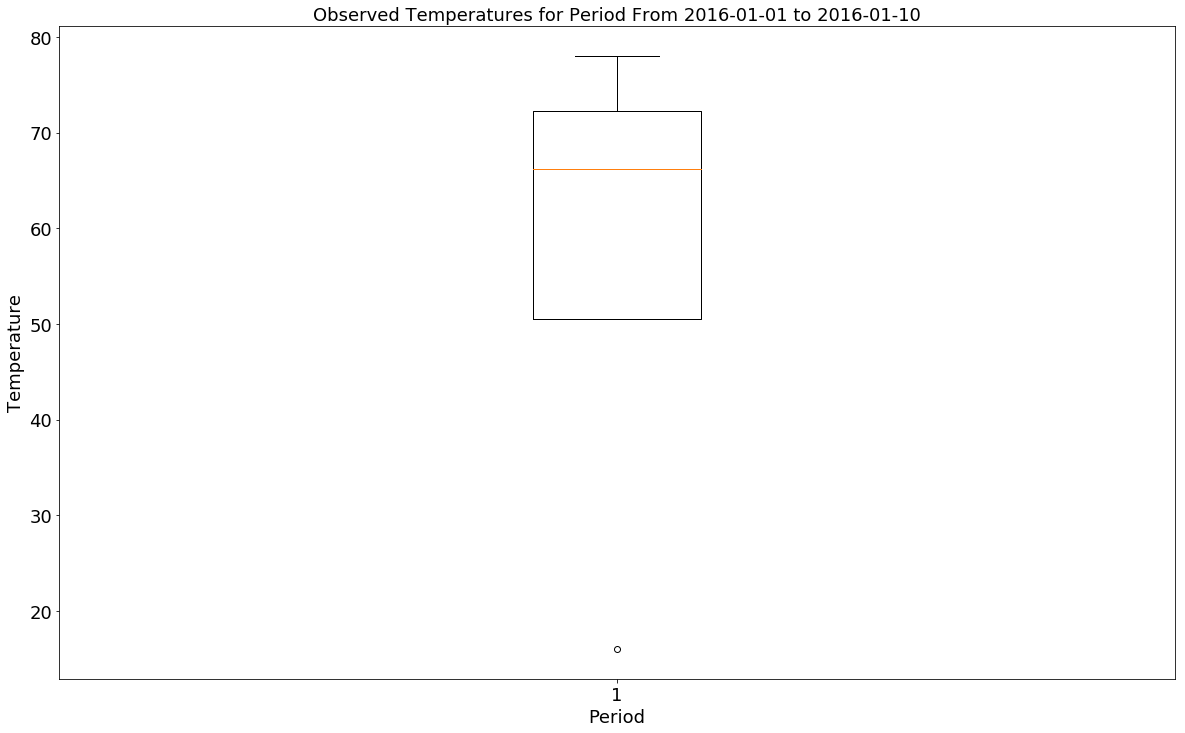

In [35]:
data =[max_t - min_t, avg_t, max_t, min_t]
plt.figure(figsize=(20,12))
plt.title('Observed Temperatures for Period From {} to {}'.format(vacation_start, vacation_end), fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.xlabel('Period', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.boxplot(data)
plt.show()